# Transformée de Laplace inverse

Le but est de déterminer numériquement la transformée de Laplace inverse par les méthodes de Stehfest et de Talbot.




## Références :
- [1] https://fr.wikipedia.org/wiki/Transformation_inverse_de_Laplace
- [2] http://www.columbia.edu/~ww2040/JoC.pdf (Abate et al. `A Unified Framework for Numerically Inverting Laplace Transforms`)
- [3] https://doi.org/10.1002/nme.995 (Abate et al. `Multi-precision Laplace transform inversion`)





In [4]:
#quelques modules nécessaires
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math as m
from mpmath import *

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 600
mpl.rc('axes', labelsize=12, titlesize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)


## Méthode de Gaver-Stehfest

D'abord donnons nous une fonction `v_stehfest` pour déterminer la relation (32) de [2] c'est à dire :

$$
\zeta_k = (-1)^{M+k} \sum_{j=\lfloor(k+1)/2\rfloor}^{\min{(k,M)}} \dfrac{j^{M+1}}{M!}\begin{pmatrix} M\\j\end{pmatrix}\begin{pmatrix} 2j\\j\end{pmatrix}\begin{pmatrix} j\\k-j\end{pmatrix}
$$

avec $\lfloor x \rfloor$ le plus grand entier inférieur ou égal à $x$

In [7]:
def coeff_bin(n,k):
    """
    Coefficients binomiaux :
         k          n!
       C     = -------------
        n       k! (n-k)!
    """
    a=fac(n)
    b=fac(k)
    c=fac(n-k)
    return mpf(1)*a/(b*c)

# test des coefficients binomiaux
print("1.0")
for n in range(6):
    print('1.0',end=' ')
    for k in range(n):
        print(coeff_bin(n+1,k+1),end=' ')
    print('1.0')

1.0
1.0 1.0
1.0 2.0 1.0
1.0 3.0 3.0 1.0
1.0 4.0 6.0 4.0 1.0
1.0 5.0 10.0 10.0 5.0 1.0
1.0 6.0 15.0 20.0 15.0 6.0 1.0


In [131]:
def zeta_stehfest(N):
    """
    Coefficients zeta de la relation (32) de
    http://www.columbia.edu/~ww2040/JoC.pdf
    """
    if N%2 !=0 :
        N+=1
    M=N//2
    mp.dps=2.2*M
    zeta=np.zeros(N,dtype=mpf)
    for k in range(1,2*M+1):
        coeff=(-1)**(M+k)/np.math.factorial(M)
        jmi=(k+1)//2
        jma=min(k,M)
        sumk=0.0
        for j in range(jmi,jma+1):
            a=j**(M+1)
            c=coeff_bin(M,j)
            d=coeff_bin(2*j,j)
            e=coeff_bin(j,k-j)
            sumk+=a*c*d*e
        zeta[k-1]=sumk*coeff
    return zeta


# on peut vérifier les valeurs pour N=10 comme présentées sur [1]
for vk in zeta_stehfest(10):
    print(f"{vk}")

0.083333333333
-32.083333333
1279.0
-15623.666667
84244.166667
-236957.5
375911.66667
-340071.66667
164062.5
-32812.5


La transformée inverse par la méthode de Gaver-Stehfest est donné par (adapté de la relation (31) de [2]) :
$$
f(t)=\dfrac{\ln{2}}{t}\sum_{k=1}^{2M}\zeta_kF\left(\dfrac{k\ln{2}}{t}\right)
$$
où l'on note $f(t)$ la fonction inverse de $F(p)$.

On se donne la fonction `gaver_stehfest` qui prend en paramètre le temps `t` et `f` la $F(p)$ à inverser.

In [135]:
def gaver_stehfest(t,f,M=16):
    """
    Méthode de Gaver-Stehfest
    (equation 31) JcO.pdf
    """
    #if M%2 !=0 :
    #    print("Error M should be even")
    #    return
    c=log(2)/t
    return c*np.sum([v*f((k+1)*c) for k,v in enumerate(zeta_stehfest(M))],dtype=mpf)

print(exp(-1))
print(gaver_stehfest(1,lambda p: 1/(p+1)**2,M=37))


0.36787944117144232159552377016146086744581
0.3678794411714423124751661433247130955831


## Test de la méthode de Gaver-Stehfest

On souhaite inverser la fonction $F(p)=\dfrac{1}{(p+1)^2}$ dont la fonction inverse est donnée analytiquement par $f(t)=te^{-t}$.

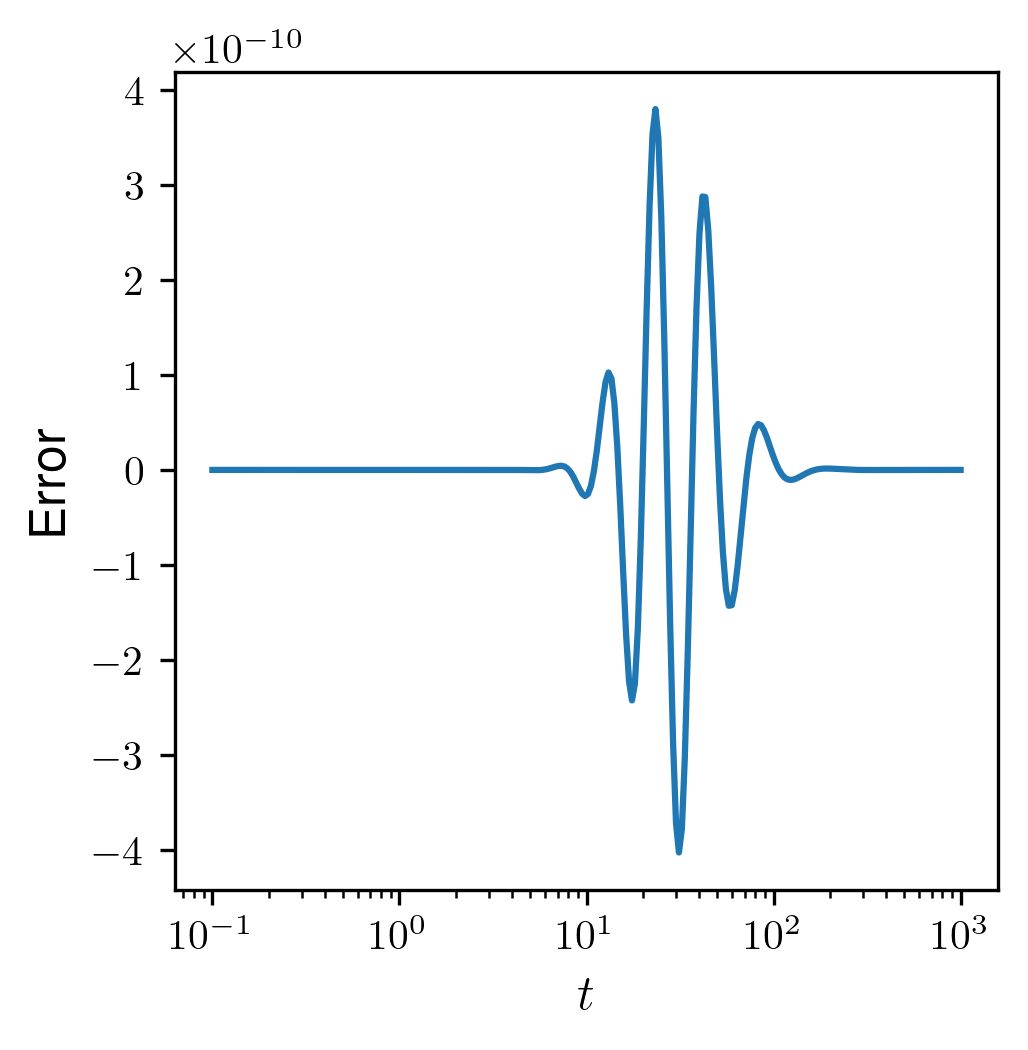

In [136]:
ft=lambda t : t*exp(-t)
fp=lambda p : mpf(1.0)/(p+1)**2


mp.dps=100
M=40
t=np.logspace(-1,3,256)
f_gaver_stehfest=np.array([gaver_stehfest(tk,fp,M) for tk in t])
#f_gaver_stehfest2=np.array([invertlaplace(fp,tk,method='stehfest',degree=M) for tk in t])
f_analytic=np.array([ft(tk) for tk in t])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3.54,3.54))
ax.set_xlabel('$t$')
ax.set_ylabel('Error')
ax.plot(t,(f_gaver_stehfest-f_analytic))
#ax.plot(t,(f_gaver_stehfest2-f_analytic))

ax.set_xscale('log')
plt.savefig("fig/erreur_gaver-stehfest.png")
plt.show()

## Algorithme fixe de Talbot 
On souhaite se donner la relation (18) de [3] qui se présente de la forme :
$$
f(t) = \dfrac{r}{M} \left\{ \dfrac{1}{2} F(r) e^{rt}+ \sum_{k=1}^{M-1} \textrm{Re}{\left[ e^{ts(\theta_k)} F(s(\theta_k)) (1+i\sigma(\theta_k)) \right]} \right\}
$$
avec $\theta_k=\dfrac{k\pi}{M}$.

Les relations (19), (16) et (11) de [3] respectivements: 
$$
r=\dfrac{2M}{5t}
$$
$$
\sigma(\theta)=\theta+(\theta\cot\theta-1)\cot\theta
$$ 
$$
s(\theta)=r\theta(\cot\theta+i)
$$
sont nécessaires pour implémenter la méthode.


In [48]:
def talbot(t,f,M=20):
    """
    Algorithme fixe de Talbot :
    Equation (18) abate2004.pdf
    """
    r=mpf(1.0)*2.0*M/(5.0*t)
    sumk=0.5*f(r)*exp(r*t)
    step=pi/M
    for k in range(1,M):
        tk=k*step
        cotk=1.0/tan(tk)
        stk=r*tk*(cotk+1j)
        sigtk=tk+(tk*cotk-1)*cotk
        sumk_tmp=f(stk)*(1+1j*sigtk)*exp(t*stk)
        sumk+=sumk_tmp.real # real part
    return sumk*r/M

print(talbot(1,lambda p: 1/(p+1)**2,M=18))
print(exp(-1))

0.3678794411713919505
0.3678794411714423216


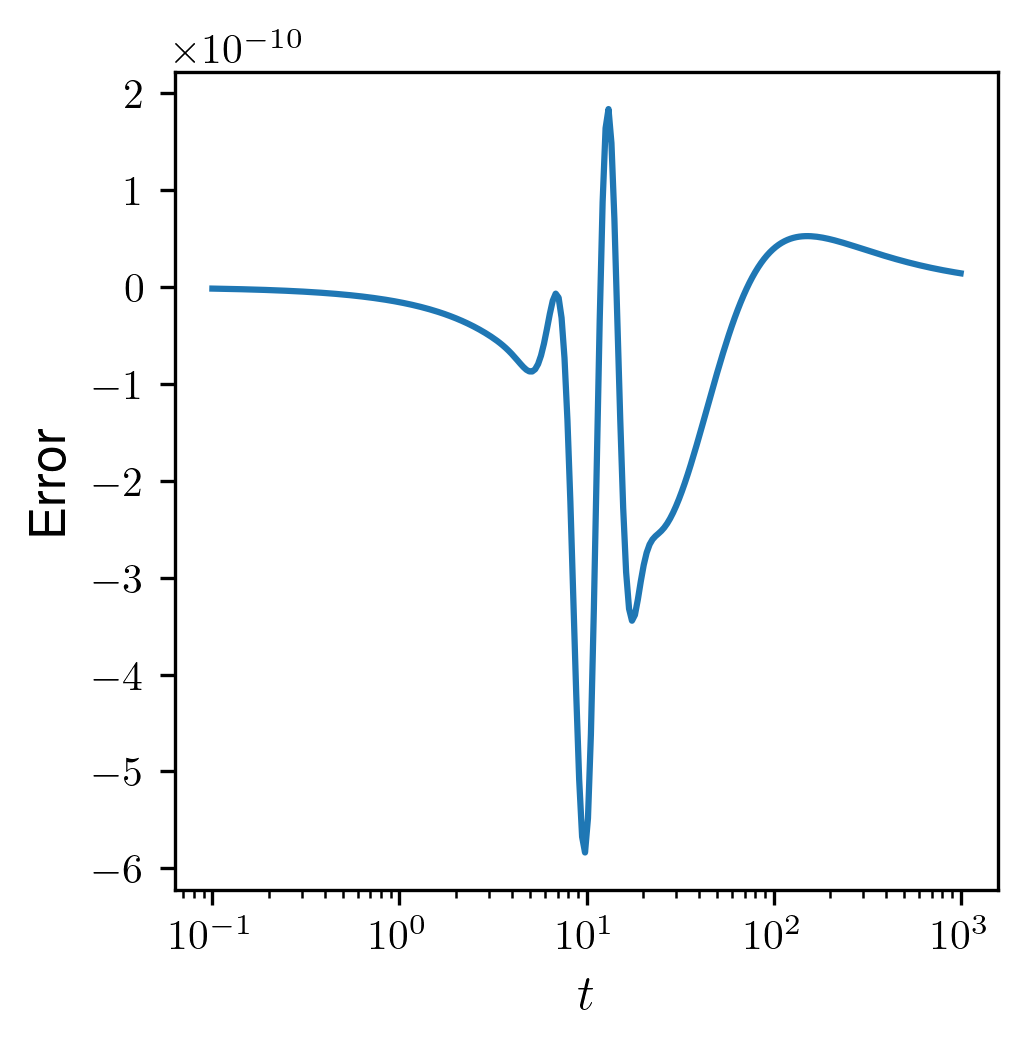

In [111]:
ft=lambda t : t*exp(-t)
fp=lambda p : 1/(p+1)**2

M=14
t=np.logspace(-1,3,256)
f_talbot=np.array([talbot(tk,fp,M) for tk in t])
f_talbot2=np.array([invertlaplace(fp,tk,method='talbot',degree=M) for tk in t])
f_analytic=np.array([ft(tk) for tk in t])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3.54,3.54))
ax.set_xlabel('$t$')
ax.set_ylabel('Error')
ax.plot(t,f_talbot-f_analytic)
#ax.plot(t,(f_talbot2-f_analytic))
ax.set_xscale('log')
plt.savefig("fig/erreur_talbot.png")
plt.show()

## Application pour les systèmes linéaires
On souhaite déterminer numériquement la réponse indicielle d'un système linéaire 
avec l'algorithme fixe de Talbot.

In [51]:
def premier_ordre(t,**kwargs):
    """
    Réponse indicielle d'un système du premier ordre :
        s(t) = K E0 ( 1 - exp(-t/tau)
    """
    K=kwargs.get('K', 1.0)
    tau=kwargs.get('tau', 1.0)
    E0=kwargs.get('E0', 1.0)
    a=np.exp(-t/tau)
    return K*E0*(1-a)

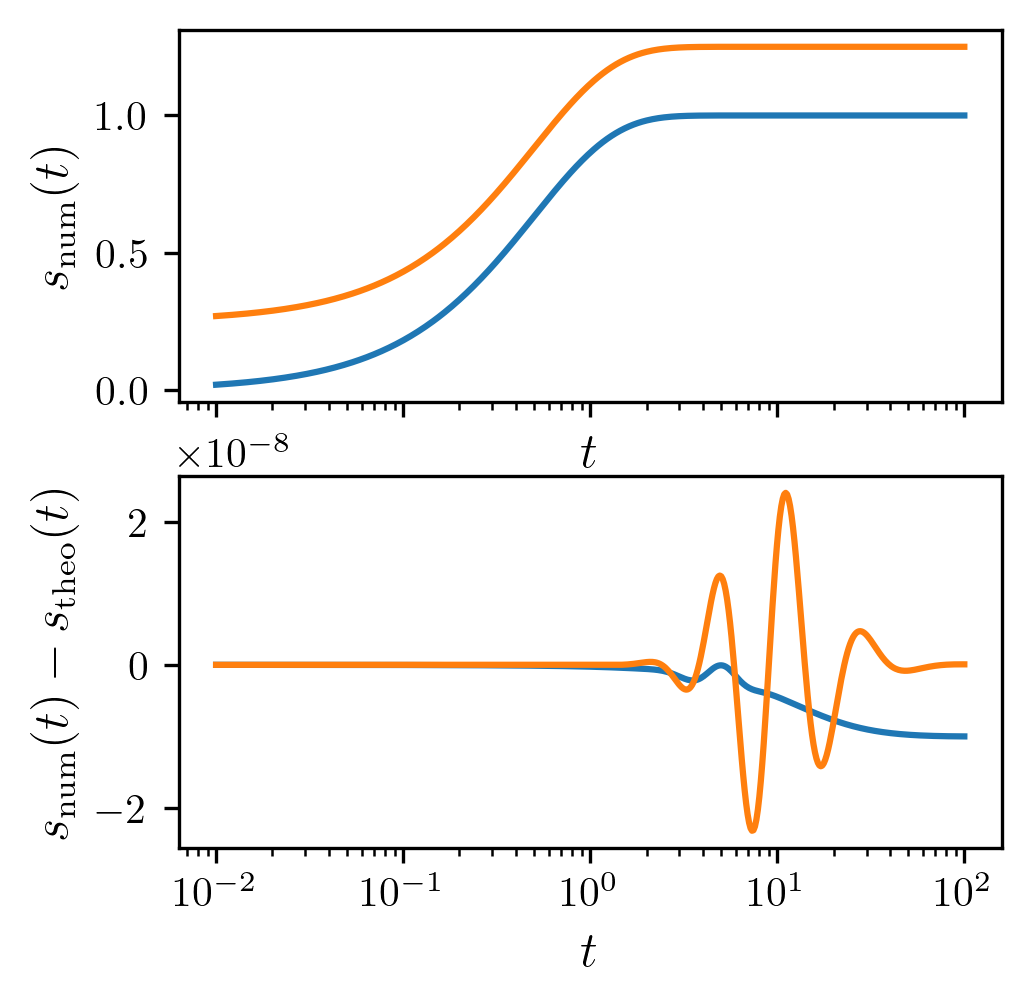

In [164]:
K=1
tau=0.5
E0=1
H=lambda p: K/(tau*p+1)
E=lambda p: E0/p
S=lambda p: H(p)*E(p)

t=np.logspace(-2,2,512)
M=12
s1=np.array([talbot(tk,S,M) for tk in t])
s2=np.array([gaver_stehfest(tk,S,int(M*2.3)) for tk in t])
po=np.array([premier_ordre(tk,K=K,tau=tau,E0=E0) for tk in t])

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(3.54,3.54),sharex = True)
ax1.plot(t,s1)
ax1.plot(t,s2+0.25)
ax2.plot(t,s1-po)
ax2.plot(t,s2-po)
ax1.set_xlabel("$t$")
ax1.set_ylabel("$s_{\mathrm{num}}(t)$")
ax2.set_xlabel("$t$")
ax2.set_ylabel("$s_{\mathrm{num}}(t)-s_{\mathrm{theo}}(t)$")
ax1.set_xscale('log')
plt.savefig("fig/1er_ordre_talbot.png")
plt.show()

In [75]:
def second_ordre(t,**kwargs):
    """
    Réponse indicielle d'un système du second ordre. La forme
    dépend de z (le coefficient d'amortissement)
    """
    K=kwargs.get('K', 1.0)
    w=kwargs.get('w', 1.0)
    z=kwargs.get('z', 1.0)
    E0=kwargs.get('E0', 1.0)

    if z <= 0.0 :
        return
    else:
        alpha = z*w
    if z > 1.0 :
        b=np.sqrt(z*z-1)
        wd=w*b
        p1=-alpha+wd
        p2=-alpha-wd
        a1=np.exp(t*p1)
        a2=np.exp(t*p2)
        p1p2=p1-p2
        return K*E0*(1+(1.0/p1p2)*(p2*a1-p1*a2))
    if z == 1.0:
        p1=-w
        a1=np.exp(t*p1)
        return K*E0*(1-a1+p1*t*a1)
    if z < 1.0:
        b=np.sqrt(1-z*z)
        wd=w*b
        phi=np.arctan(b/z)
        a1=np.exp(-alpha*t)
        c=np.sin(wd*t+phi)
        return K*E0*(1-a1*c/b)

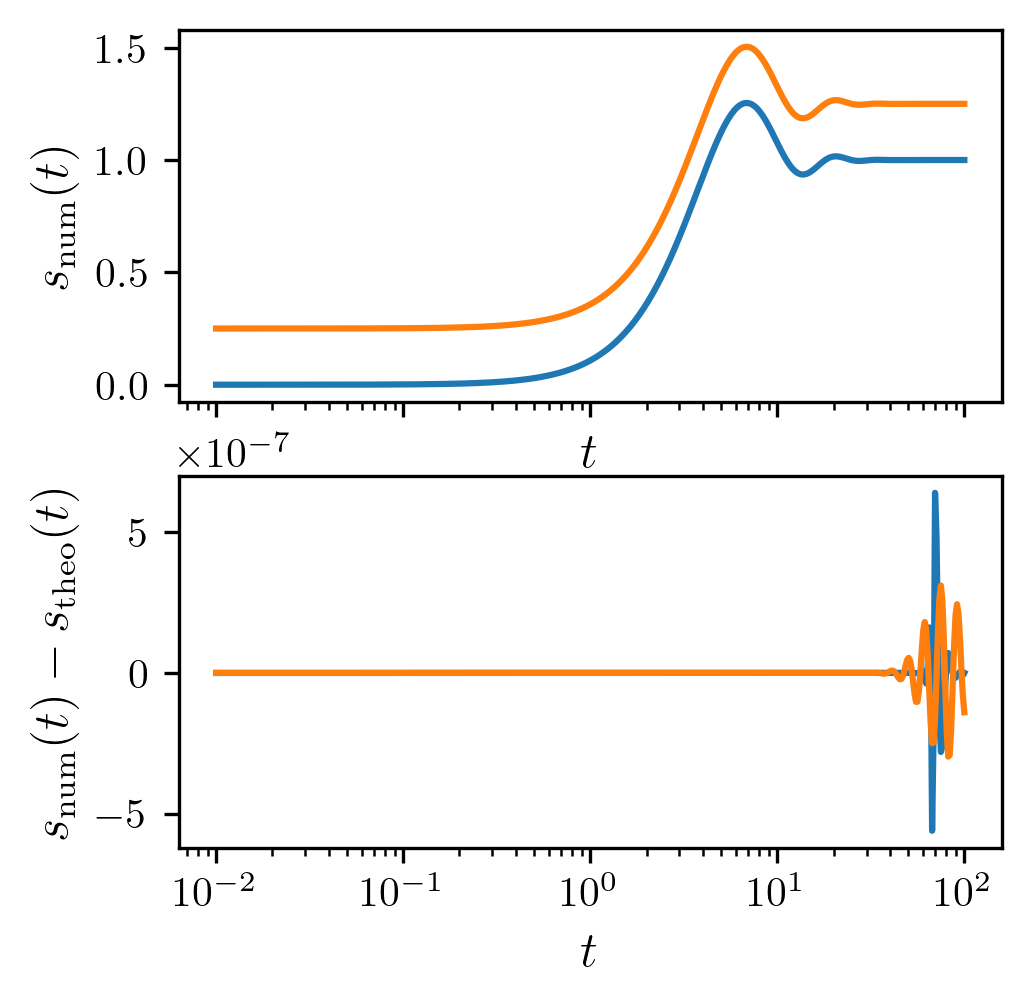

In [162]:
# les paramètres et le fonctions analytiques pour comparaison
K=1.0
w=0.5
z=0.4
E0=1.0
H=lambda p: (K*w*w)/(p*p+2*z*w*p+w*w)
E=lambda p: E0/p
S=lambda p: H(p)*E(p)
from mpmath import *
# vecteur temps
t=np.logspace(-2,2,512)
# transformée inverse numérique
M=40
s1=np.array([talbot(tk,S,M) for tk in t])
s2=np.array([gaver_stehfest(tk,S,int(M*1.8)) for tk in t])
so=np.array([second_ordre(tk,K=K,w=w,z=z,E0=E0) for tk in t])

#tracé des résultats
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(3.54,3.54),sharex = True)
ax1.plot(t,s1)
ax1.plot(t,s2+0.25)

ax2.plot(t,s1-so)
ax2.plot(t,s2-so)
ax1.set_xlabel("$t$")
ax1.set_ylabel("$s_{\mathrm{num}}(t)$")
ax2.set_xlabel("$t$")
ax2.set_ylabel("$s_{\mathrm{num}}(t)-s_{\mathrm{theo}}(t)$")
ax1.set_xscale('log')
plt.savefig("fig/2nd_ordre_talbot.png")
plt.show()